In [1]:
#Importing all necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

# Plant Generation Data
df_gen = pd.read_csv('Plant_2_Generation_Data.csv')
# Plant Weather Data
df_weather = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

#Displaying first 5 rows, to make sure that the data is bieng read correctly
df_gen.head()
df_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [2]:
#Displaying mathematical information
df_gen.describe()
df_weather.describe()

print('Plant ID ',df_gen.PLANT_ID.nunique())
print('No. of Inverters ',df_gen.SOURCE_KEY.nunique())
print('No. of Unique Source key',df_weather.SOURCE_KEY.nunique())
print('Null values in generation data: \n',df_gen.isnull().sum())
print('Null values in generation data: \n',df_weather.isnull().sum())

Plant ID  1
No. of Inverters  22
No. of Unique Source key 1
Null values in generation data: 
 DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
Null values in generation data: 
 DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [3]:
#PLANT_ID and SOURCE_KEY is same for all records so can be dropped from both the datasets.
#SOURCE_KEY is a unique Inverter ID so will replace it with Inverter No. for simplicity using mapping & then drop the SOURCE_KEY column in both datasets.
df_gen.drop('PLANT_ID', axis=1, inplace=True)
df_weather.drop('PLANT_ID', axis = 1, inplace=True)

# Mapping
Inverter_labels = {inverter_no:inverter_name for inverter_name,inverter_no in enumerate(df_gen['SOURCE_KEY'].unique(),1)}
df_gen['Inverter_No'] = df_gen['SOURCE_KEY'].map(Inverter_labels)

# Drop Source Key after replacing with inverter numbers
df_gen.drop('SOURCE_KEY',axis=1,inplace=True)
df_weather.drop('SOURCE_KEY',axis=1,inplace=True)
#Reordering and dropping Daily yield and Total yield, Daily yield and Total yield columns can be useful in Inverter-wise analysis like comparing the daily yields of inverter connected Solar modules, module fault analysis, maintenance/cleaning requirement, shadowing effect individually and Plant performance analysis but here our aim is to forecast generation, so will drop these too.
df_gen = df_gen[['DATE_TIME','Inverter_No' ,'DC_POWER', 'AC_POWER']]
#checking for missing values inverter-wise
print('Inverter {} has data for {} timestamps(Minimum)'.
      format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().argmin()+1,df_gen.groupby('Inverter_No')['DATE_TIME'].count().min()))
print('Inverter {} has data for {} timestamps(Maximum)'.
      format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().argmax()+1,df_gen.groupby('Inverter_No')['DATE_TIME'].count().max()))
print('DIFFERENCE = {}'.format(df_gen.groupby('Inverter_No')['DATE_TIME'].count().max() - df_gen.groupby('Inverter_No')['DATE_TIME'].count().min()))
#Inverters have data missing for different time stamps with a maximum difference of 904 time blocks. These missing values have to be imputed or removed so that each timestamp has values of all Inverters.

Inverter 5 has data for 2355 timestamps(Minimum)
Inverter 2 has data for 3259 timestamps(Maximum)
DIFFERENCE = 904


In [4]:
#Data Preprocessing
#Currently the data is being repeated for each timestamp inverter wise, but in this project we want our predictions to be plant level day wise. Hence the desired format is day wise.
#For this, we shall first group our data inverter wise & store each group in a list. Then will merge each group with the next one using outer join on DATE_TIME column using ‘reduce’.
from functools import reduce
# Function to rename columns in each DataFrame
def rename_columns(df, suffix):
    renamed_columns = {col: f"{col}_{suffix}" for col in df.columns if col != 'DATE_TIME'}
    return df.rename(columns=renamed_columns)

# Grouping by Inverter_No
grouped = df_gen.groupby('Inverter_No')

# Making a list of each Inverter group with renamed columns
dfs = []
for i, group in enumerate(df_gen['Inverter_No'].unique(), start=1):
    df_group = grouped.get_group(group)
    dfs.append(rename_columns(df_group, i))

# Merging data inverter-wise using 'reduce'
df_new = reduce(lambda left, right: pd.merge(left, right, on=['DATE_TIME'], how='outer'), dfs)

# Displaying the new DataFrame
display(df_new)

,DATE_TIME,Inverter_No_1,DC_POWER_1,AC_POWER_1,Inverter_No_2,DC_POWER_2,AC_POWER_2,Inverter_No_3,DC_POWER_3,AC_POWER_3,...,AC_POWER_19,Inverter_No_20,DC_POWER_20,AC_POWER_20,Inverter_No_21,DC_POWER_21,AC_POWER_21,Inverter_No_22,DC_POWER_22,AC_POWER_22
0,2020-05-15 00:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
1,2020-05-15 00:15:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
2,2020-05-15 00:30:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
3,2020-05-15 00:45:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
4,2020-05-15 01:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2020-05-20 13:00:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1179.653333,20,1299.906667,1267.406667,NaN,NaN,NaN,22,0.0,0.0
3255,2020-05-20 13:15:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1173.713333,20,1286.700000,1254.526667,NaN,NaN,NaN,22,0.0,0.0
3256,2020-05-20 13:30:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1116.450000,20,1224.671429,1194.050000,NaN,NaN,NaN,22,0.0,0.0
3257,2020-05-20 13:45:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1095.706667,20,1200.953333,1170.946667,NaN,NaN,NaN,22,0.0,0.0


In [5]:
#separate out DATE and TIME and make a new column named ‘BLOCK’ with each time BLOCK representing a 15 min interval using Pandas date_range function and will save in a dictionary. So, each day will have 96 time blocks from 00:00 as 1st to 23:45 as 96th. This will help in splitting during stratified training.
df_weather['DATE_TIME'] = df_weather['DATE_TIME'].astype(str)
df_new['DATE_TIME'] = df_new['DATE_TIME'].astype(str)
#Merging Generation & Weather datasets
df = df_weather.merge(df_new,left_on='DATE_TIME',right_on='DATE_TIME',how='outer')
#Generating 15 min time blocks
tb = pd.date_range('15-05-2020','16-05-2020',freq='15min')
tb=tb[:-1]
ts = tb.strftime('%H:%M')
block_dict = {}
j=1
for i in range(len(ts)):
    block_dict[ts[i]] =  j
    j+=1

# Making new columns of Time,BLOCK and Date and droping DATE_TIME column
df['TIME'] = df['DATE_TIME'].apply(lambda x:str(x)[-8:-3])
df['DATE'] = pd.to_datetime(df['DATE_TIME']).dt.date
df['BLOCK'] = pd.to_datetime(df['TIME']).astype(str).apply(lambda x:block_dict[str(x)[-8:-3]])
df.drop('DATE_TIME',axis=1,inplace=True)
#Saving the dictionary using numpy
np.save('timestamp_block_dictionary.npy',block_dict)

## Column re-ordering
cols = df.columns.tolist()
df = df[[cols[-1]]+[cols[-2]]+[cols[-3]]+cols[:-3]]

display(df)

<ipython-input-5-607ea88bd362>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BLOCK'] = pd.to_datetime(df['TIME']).astype(str).apply(lambda x:block_dict[str(x)[-8:-3]])


,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Inverter_No_1,DC_POWER_1,AC_POWER_1,Inverter_No_2,...,AC_POWER_19,Inverter_No_20,DC_POWER_20,AC_POWER_20,Inverter_No_21,DC_POWER_21,AC_POWER_21,Inverter_No_22,DC_POWER_22,AC_POWER_22
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,92,2020-06-17,22:45,23.511703,22.856201,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3255,93,2020-06-17,23:00,23.482282,22.744190,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3256,94,2020-06-17,23:15,23.354743,22.492245,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3257,95,2020-06-17,23:30,23.291048,22.373909,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


In [6]:
#Dataset is ready for analysis
#Choosing the latest 3 days for testing, and rest for training
#Getting last 3 days data
last_3_days = df['DATE'].astype(str).unique()[-3:]
df_test = df[df['DATE'].astype(str).isin(last_3_days)].sort_values(by=['DATE','BLOCK'])
#Saving Test data
df_test.reset_index(drop=True).to_csv('Test_data.csv')
#Saving all as Train for indexes not present in test data
df_train = df[~df.index.isin(df_test.index)]
df_train.to_csv('Train_data.csv')

## Checking shapes
print('Train:',df_train.shape)
print('Test:',df_test.shape)

## Check for missing values
print('No. of missing values in train dataset: ',list(df_train.isnull().sum()))

Train: (2971, 72)
Test: (288, 72)
No. of missing values in train dataset:  [0, 0, 0, 0, 0, 0, 64, 64, 64, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, 0, 0, 904, 904, 904, 64, 64, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 904, 904, 904, 0, 0, 0]


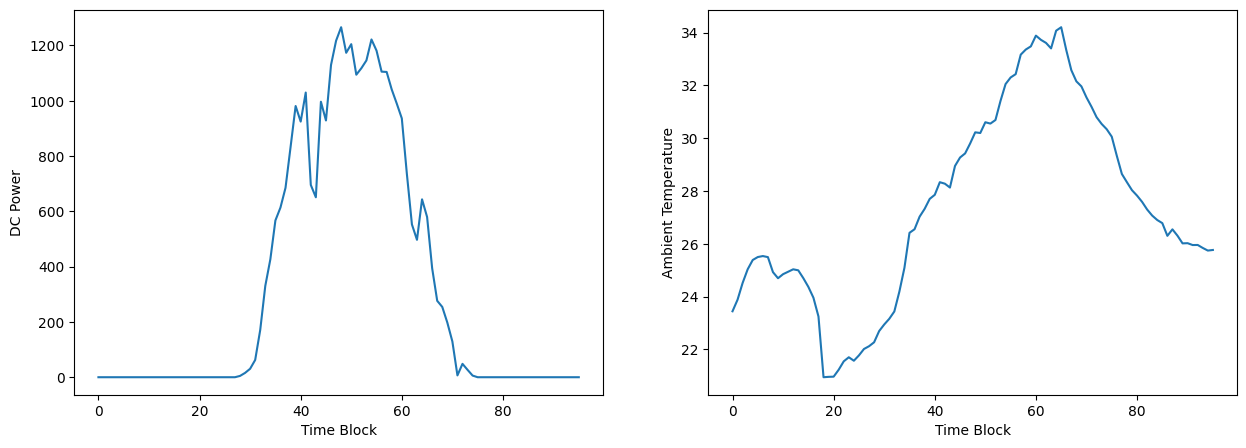

In [7]:
#Handling missing data
#The graphs are plotted for a random day
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(df_train[df_train['DATE'].astype(str)=='2020-05-18'].reset_index(drop=True)['DC_POWER_1'])
ax2.plot(df_train[df_train['DATE'].astype(str)=='2020-05-18'].reset_index(drop=True)['AMBIENT_TEMPERATURE'])
ax1.set_xlabel('Time Block')
ax1.set_ylabel('DC Power')

ax2.set_xlabel('Time Block')
ax2.set_ylabel('Ambient Temperature')
plt.show()

In [8]:
#Training Mechanism: Find the mean/median/mode for each time-block instead of population mean/median/mode from the training data and use for imputation in the test data in a block-wise manner.
#Train a model only on non-missing values to later predict the missing values.
#We will use spline interpolation
#Energy generation would be zero for non-sun hours, so we'll just input 0 in those areas.
#Mechanism used would be
#Irradiation(for solar hours), Module Temperature: Linear spline
#AC/DC Power(non-solar hours), Irradiation(non-solar hours): Zero
#AC/DC Power(solar hours): Polynomial spline(degree=2)

day_only_columns=list()
#Will collect all names like DC_POWER_1, DC_POWER_2 and so on
DC_cols = [i for i in df.columns if 'DC_POWER' in i]
AC_cols = [i for i in df.columns if 'AC_POWER' in i]
day_only_columns = DC_cols+AC_cols+["IRRADIATION"]

def Data_Preparation_Plant_Level(df):
    for col in day_only_columns:
        df[col] = df[col].astype(float)
        # For time except for non-generating hours(12 am to 6 am & 6 pm to 12 am) will be replaced by zero
        df.loc[df[(~((df['BLOCK']>24) & (df['BLOCK']<73))) & df[col].isnull()].index,col] = 0

    # Left NaN value for generating hours(6 am to 6pm)

        #1.AC & DC columns
    df[DC_cols+AC_cols].interpolate(method='polynomial',order = 2,inplace=True)
       #2.Left NaN values in Irradiation, Ambient Temp, Module Temp, Inverter_No
    df.interpolate(method='linear',inplace=True)

    # Summing up Inverter wise AC and DC values to reach Plant-level generation
    df['AC_POWER'] = df.loc[: ,AC_cols].sum(axis=1)
    df['DC_POWER'] = df.loc[:,DC_cols].sum(axis=1)
    #Scaling generation to MW from kW
    df['AC_POWER'] = df['AC_POWER']/1000
    df['DC_POWER'] = df['DC_POWER']/1000

    return df
#Applying the function on Train & Test
df_train = Data_Preparation_Plant_Level(df_train)
df_test = Data_Preparation_Plant_Level(df_test)

<ipython-input-8-8d9b3585cb82>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
<ipython-input-8-8d9b3585cb82>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
<ipython-input-8-8d9b3585cb82>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

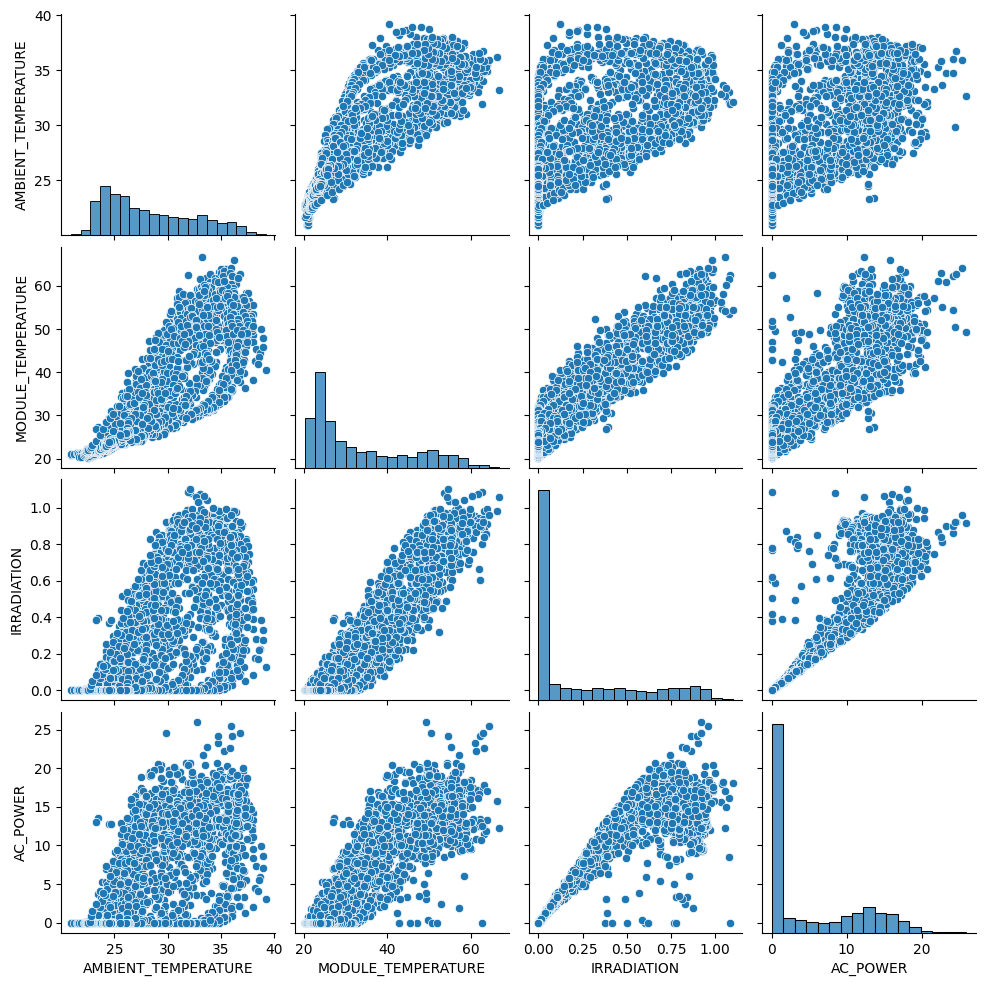

In [9]:
#Data Analysis
import seaborn as sns
sns.pairplot(df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION','AC_POWER']],height=2.5)

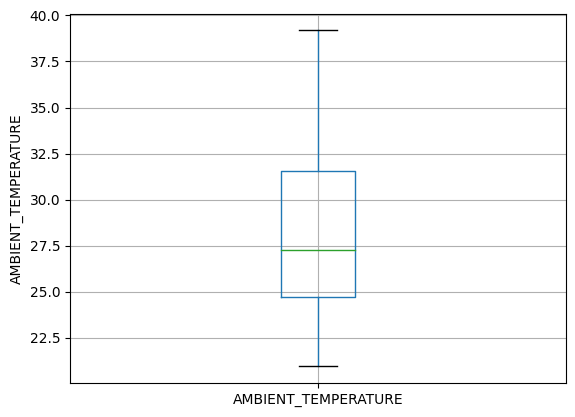

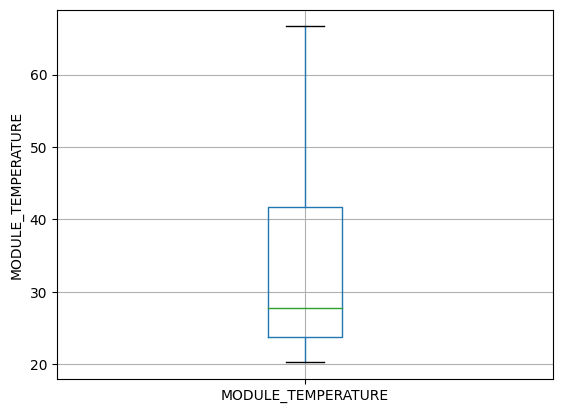

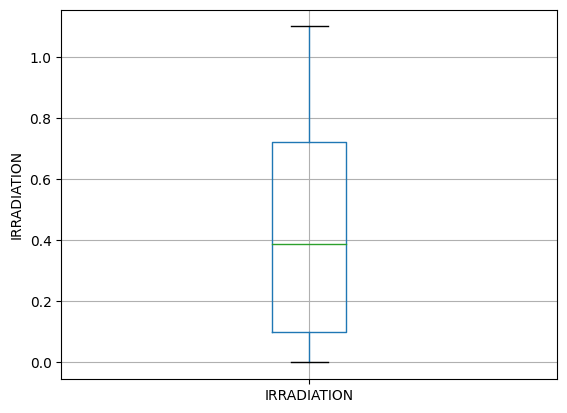

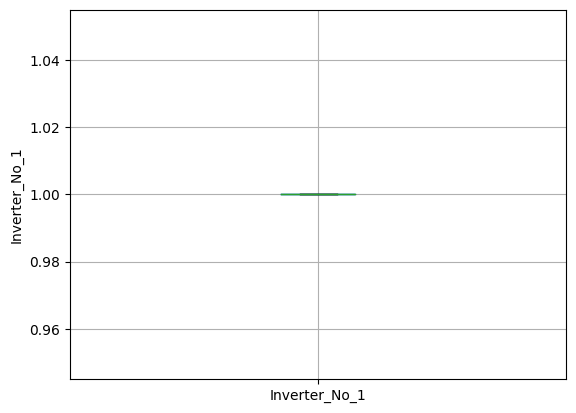

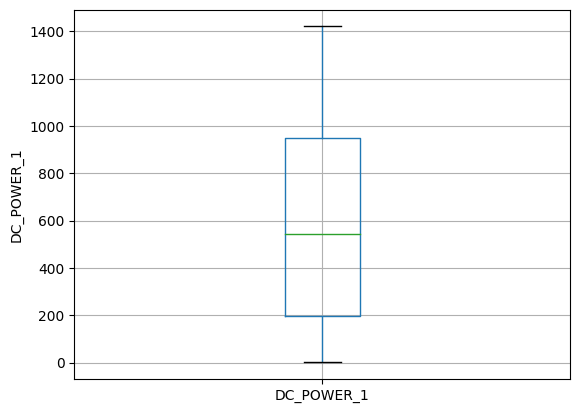

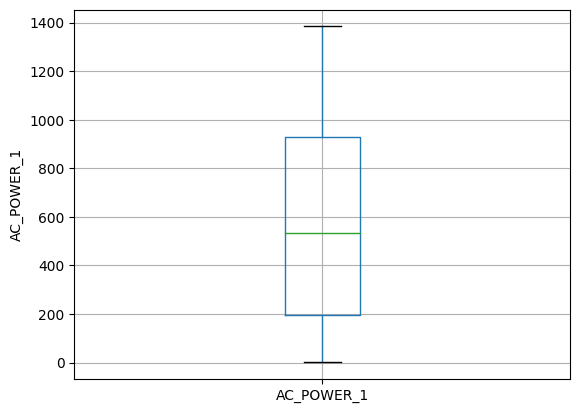

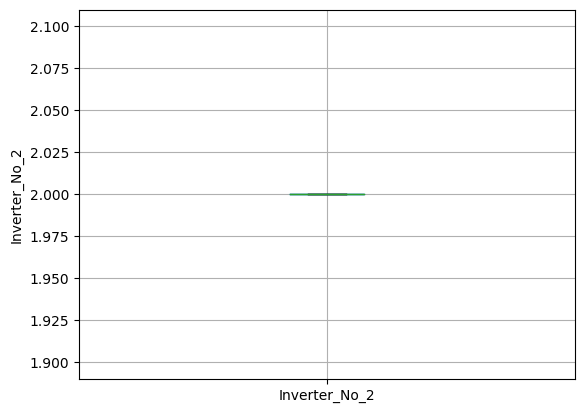

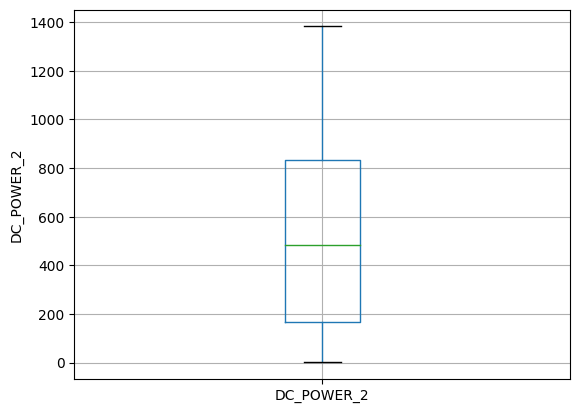

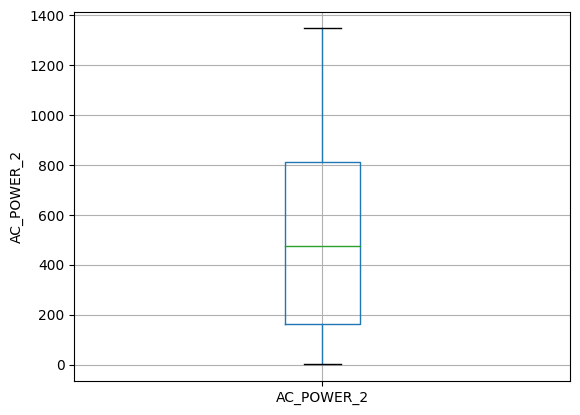

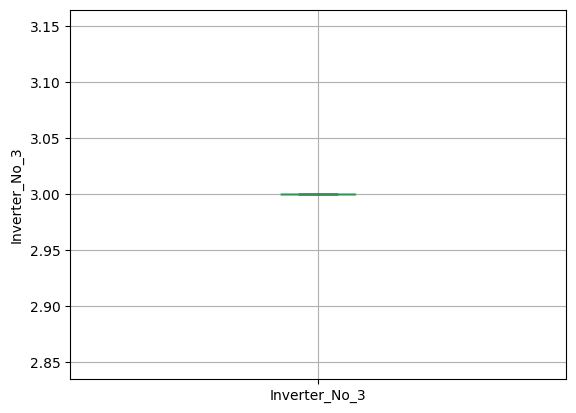

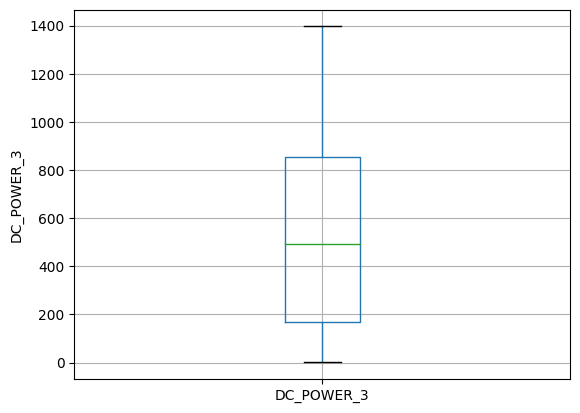

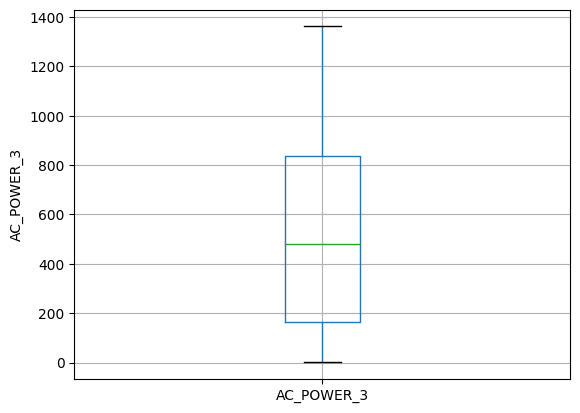

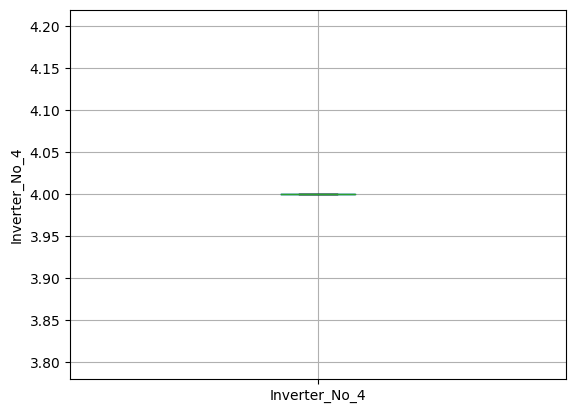

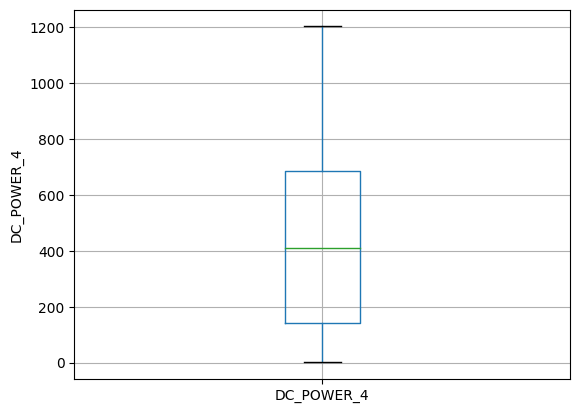

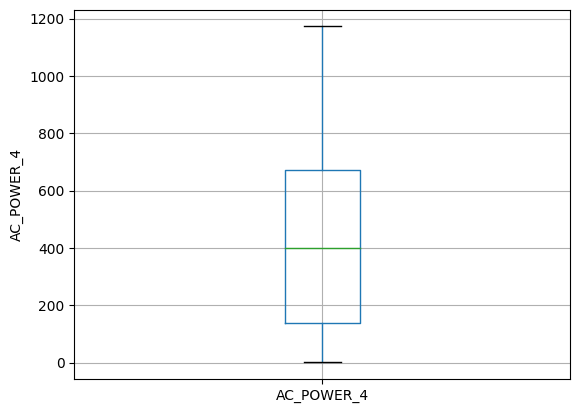

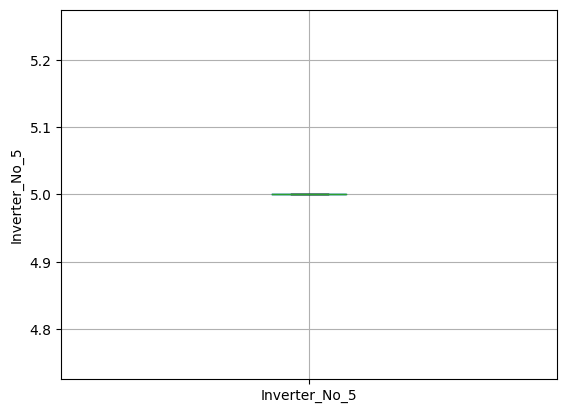

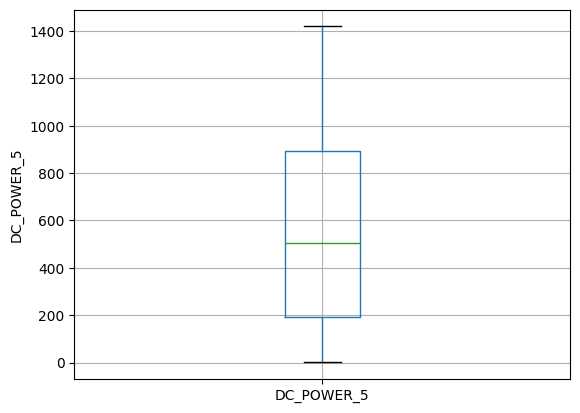

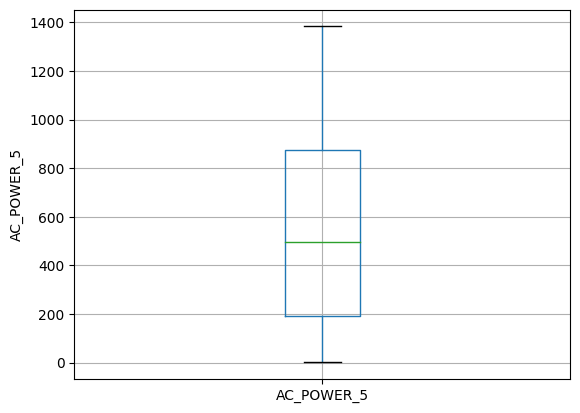

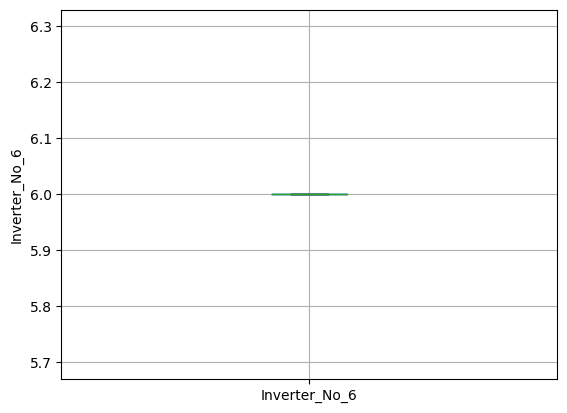

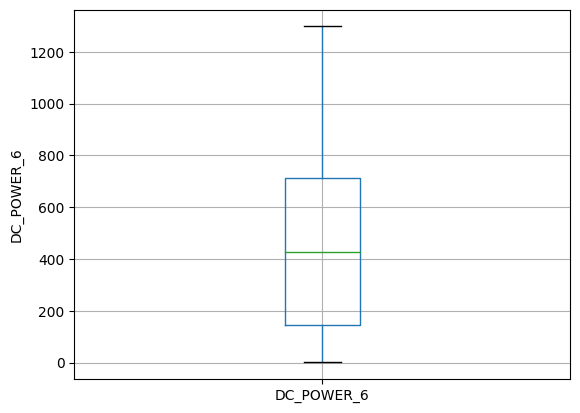

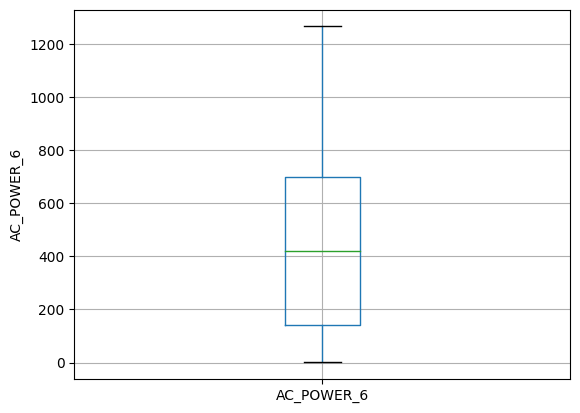

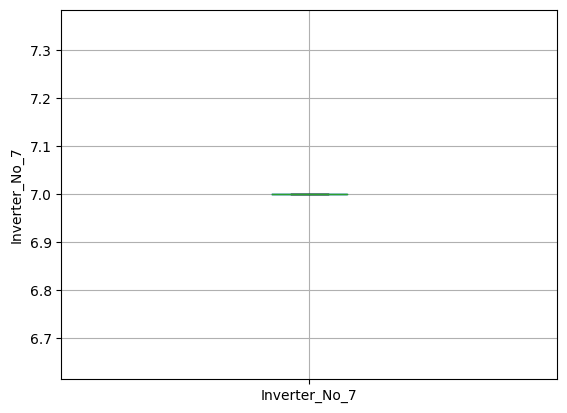

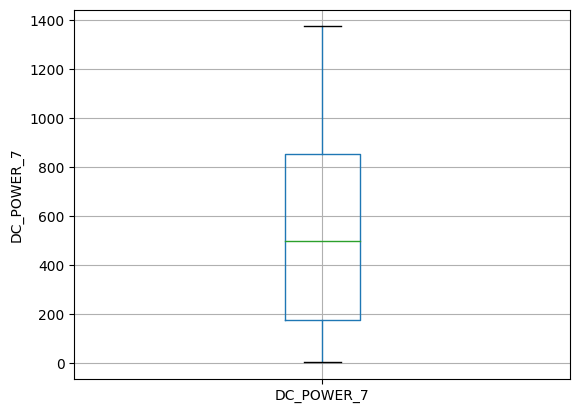

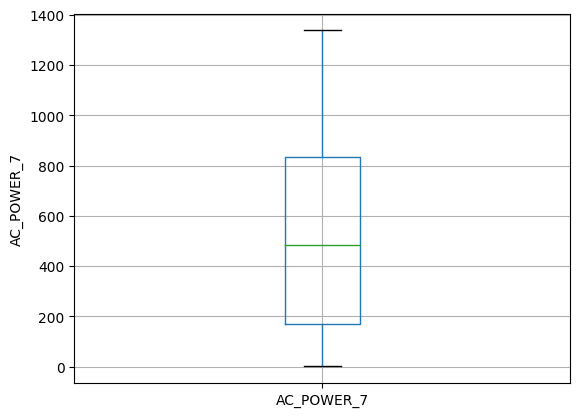

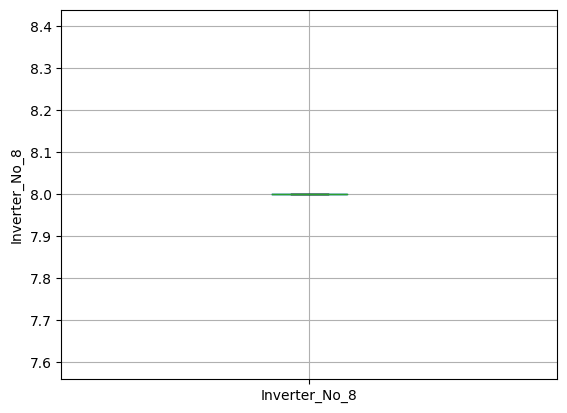

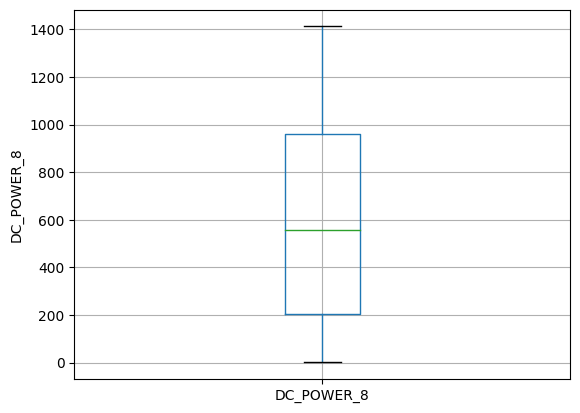

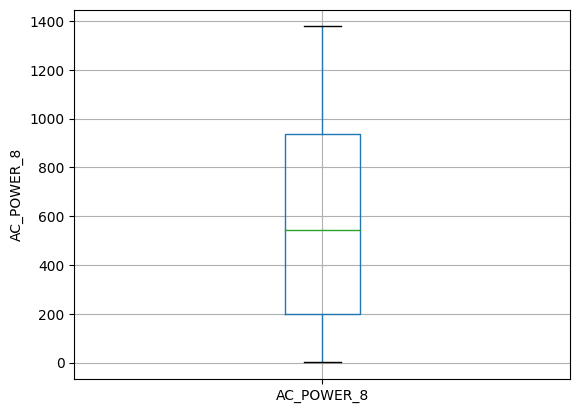

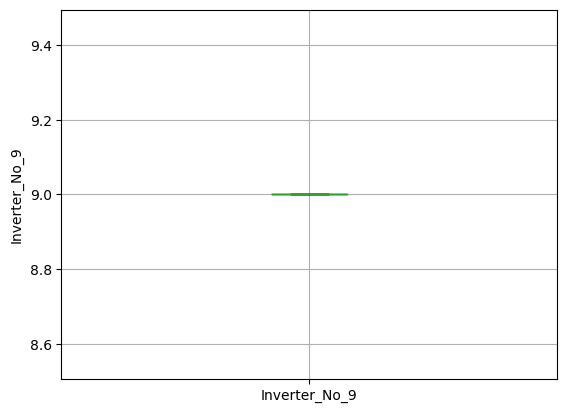

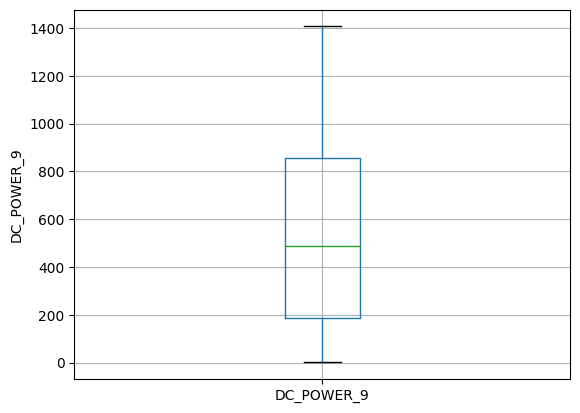

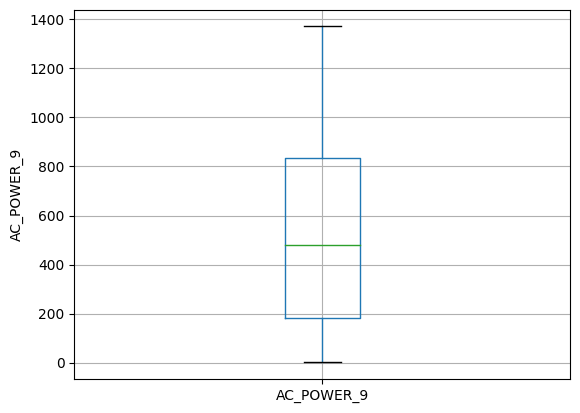

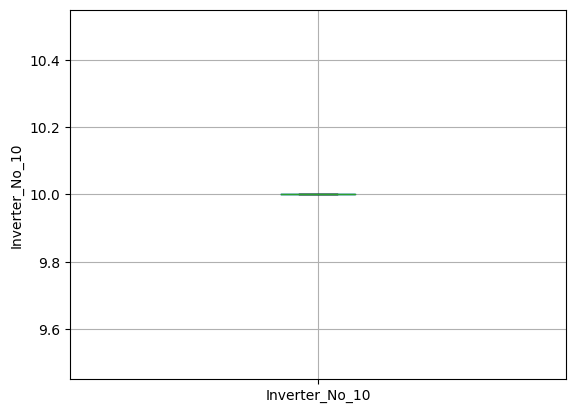

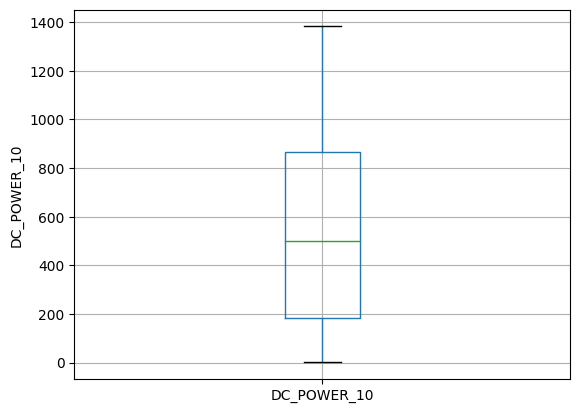

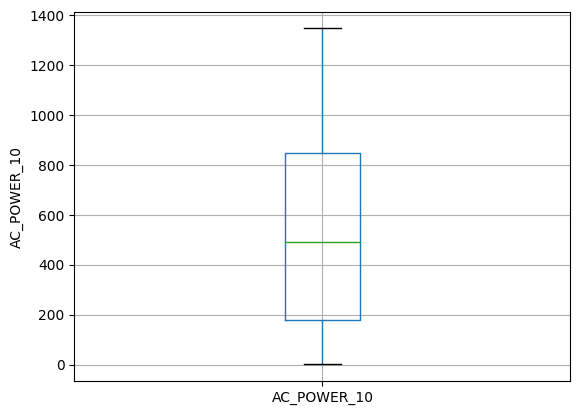

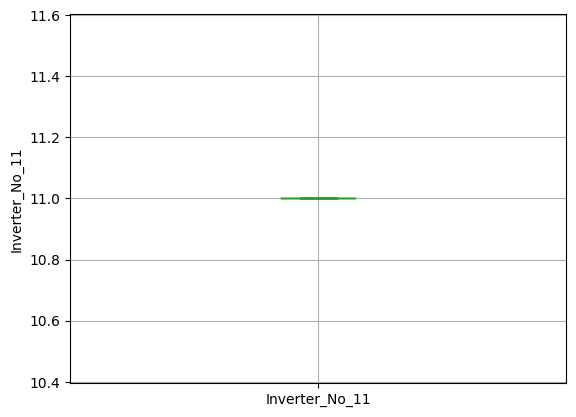

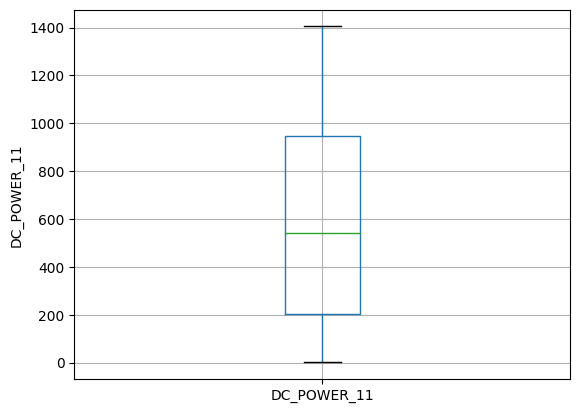

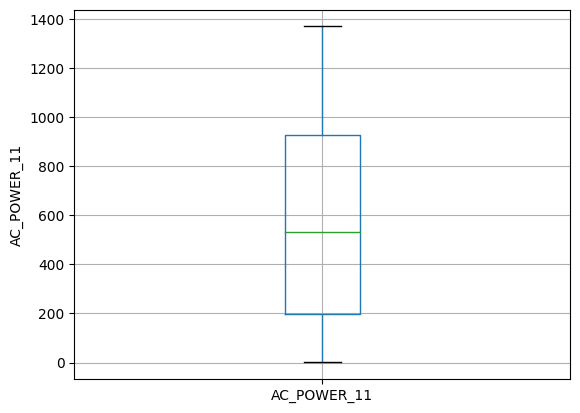

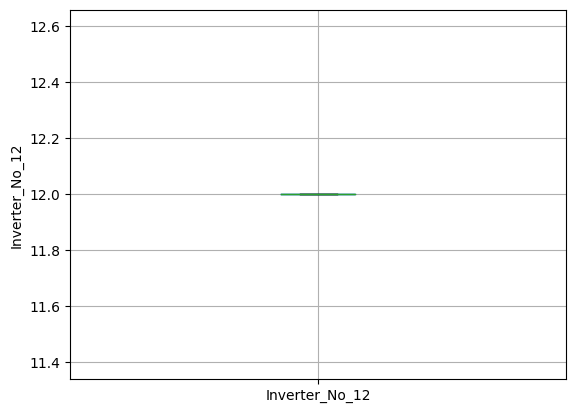

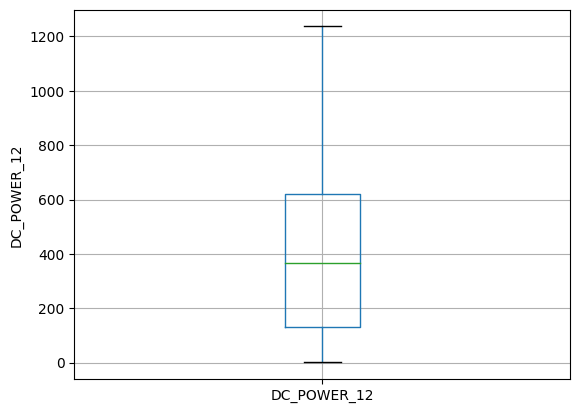

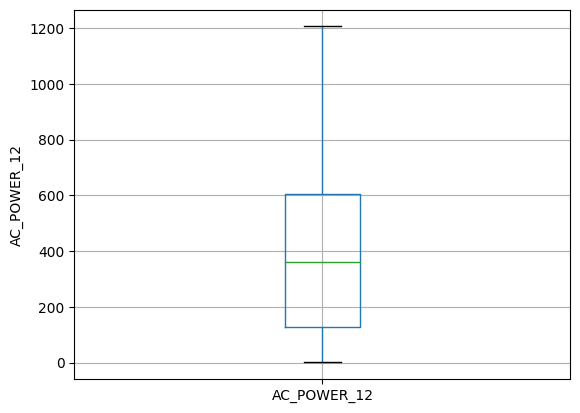

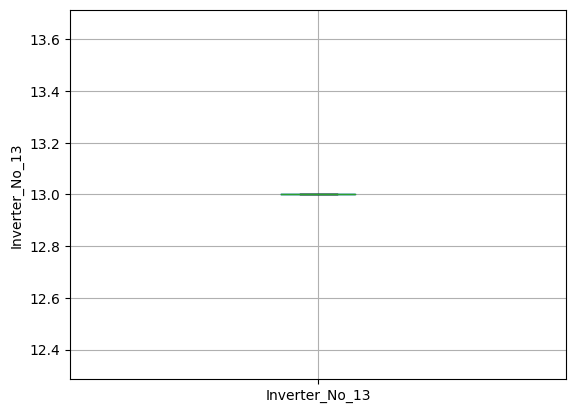

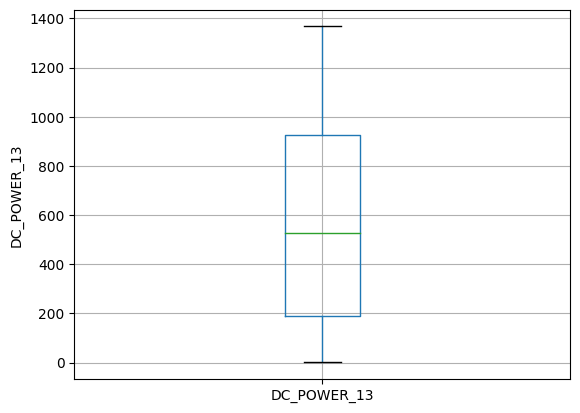

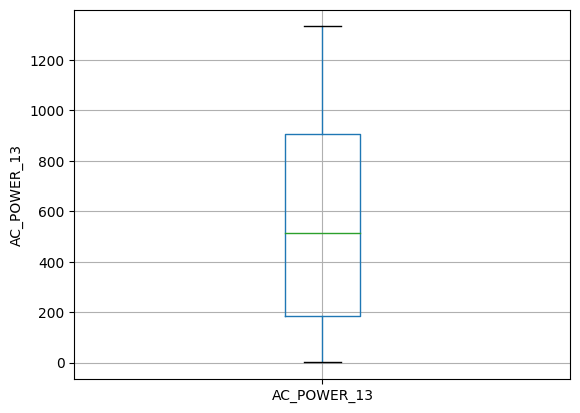

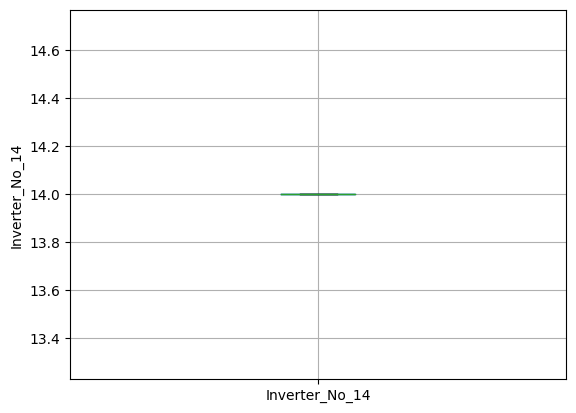

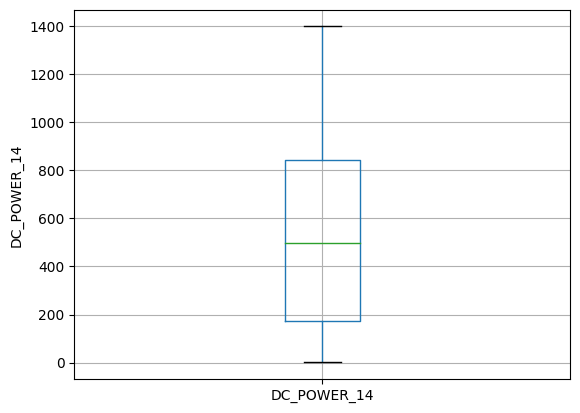

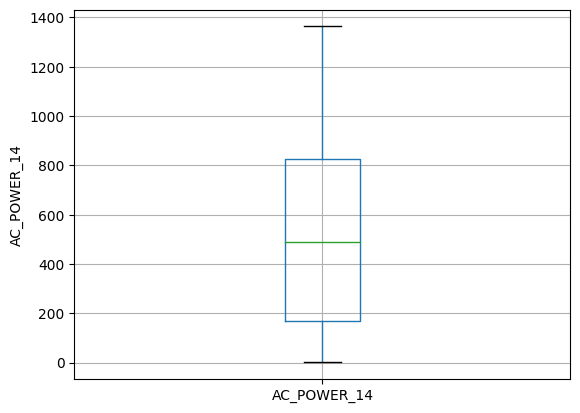

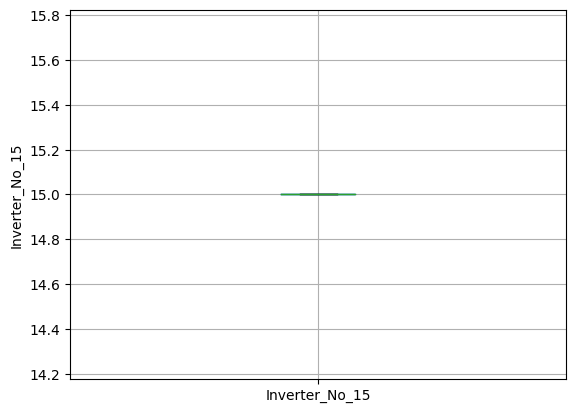

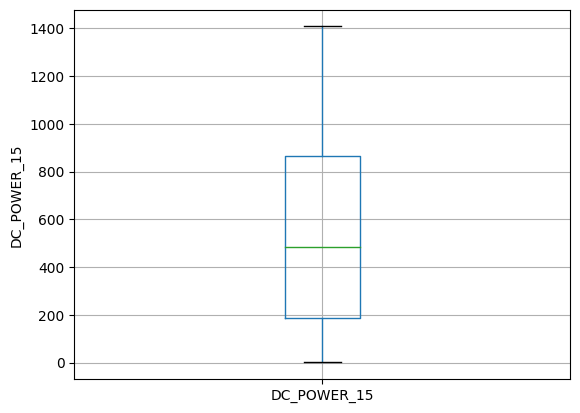

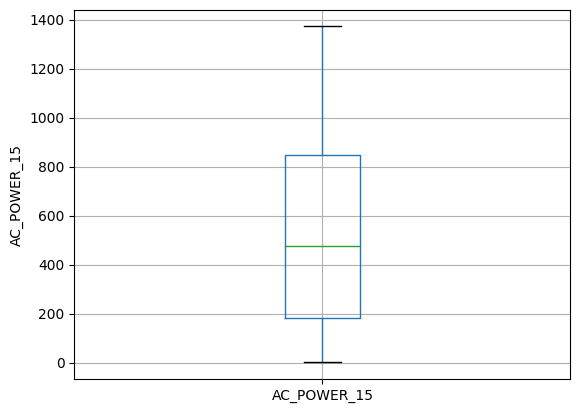

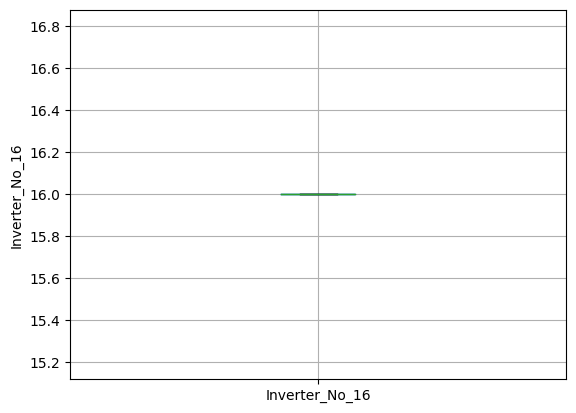

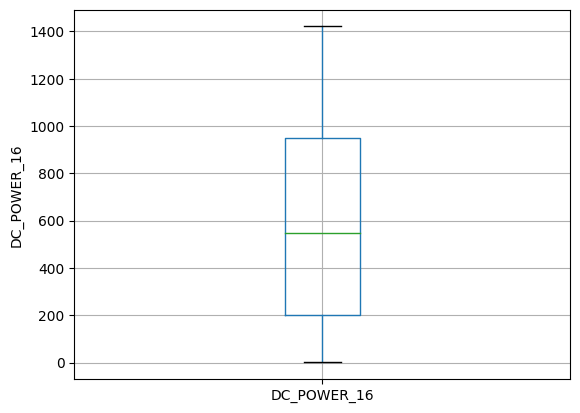

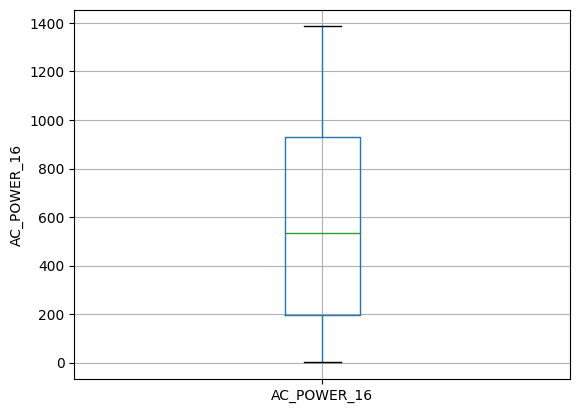

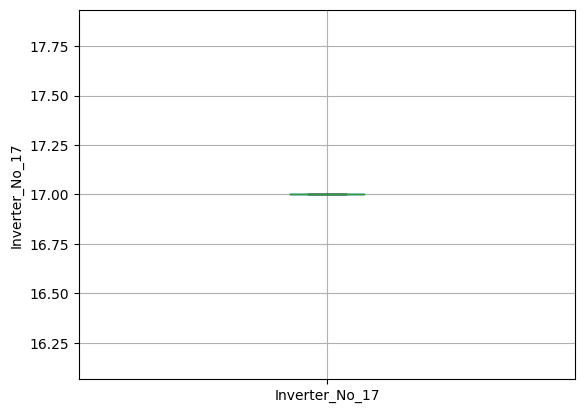

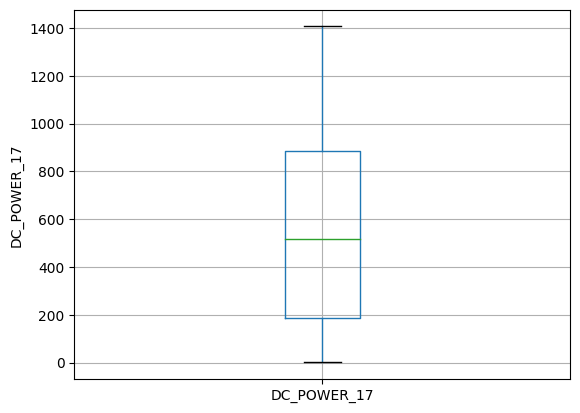

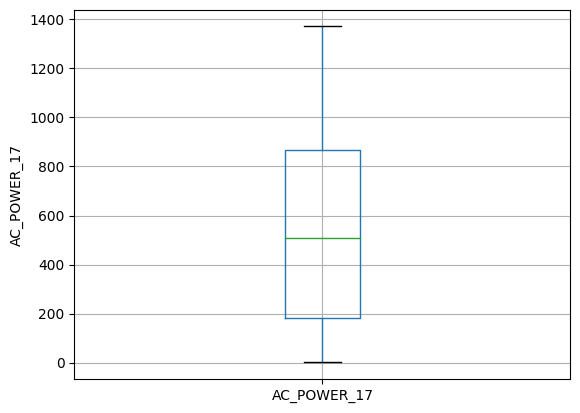

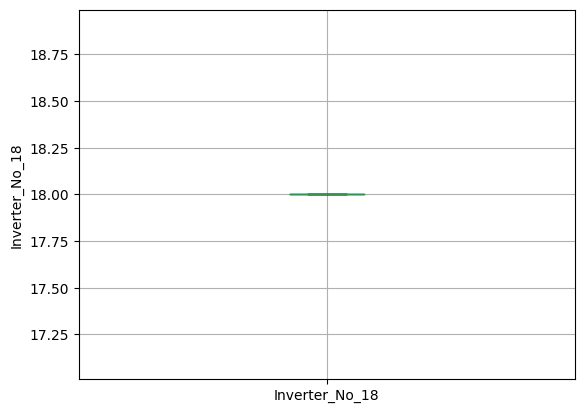

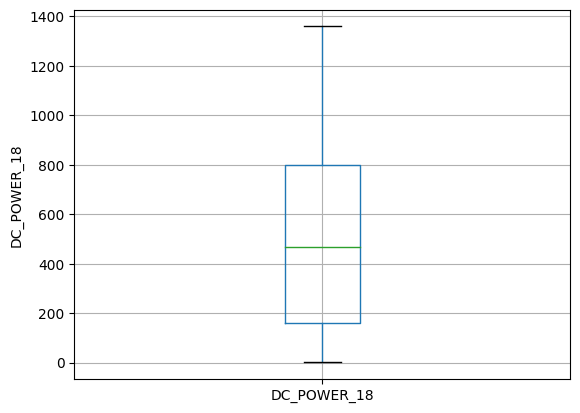

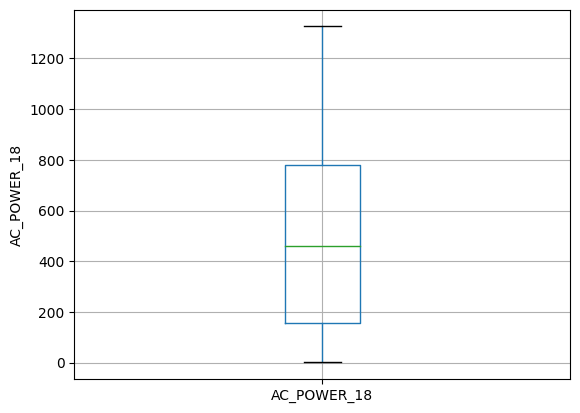

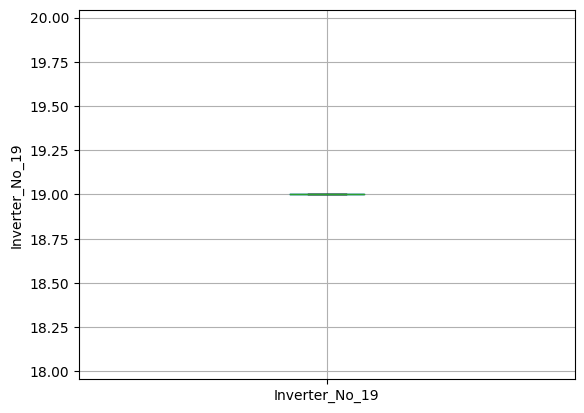

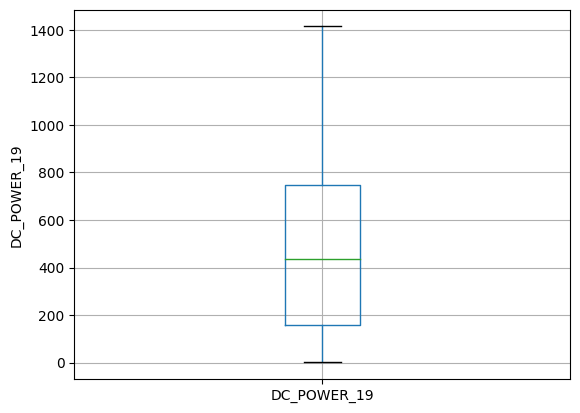

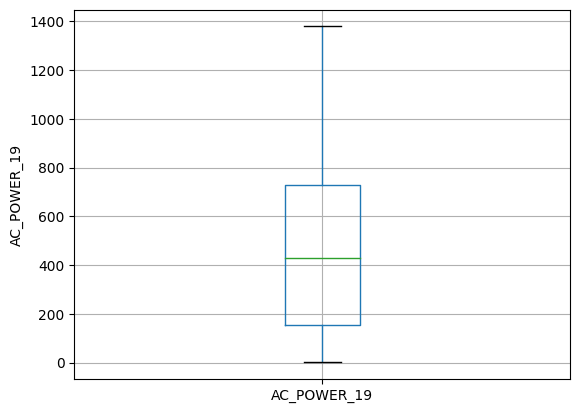

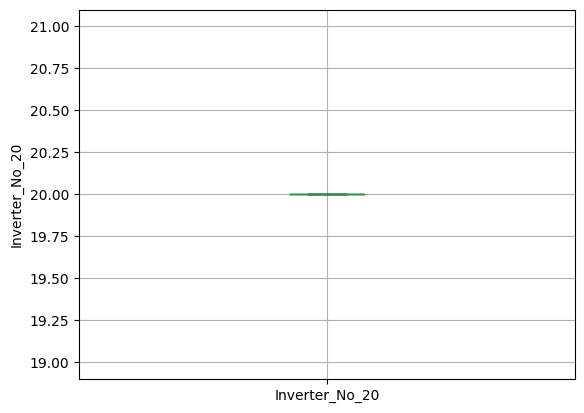

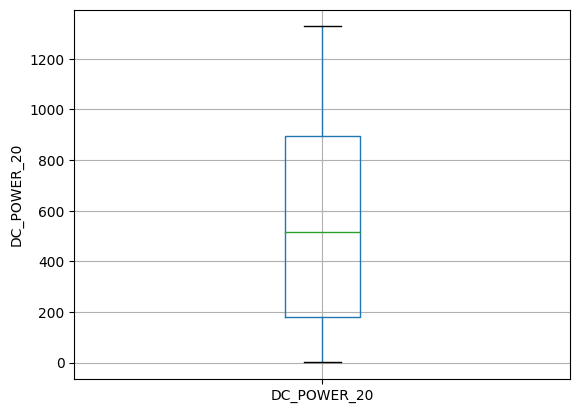

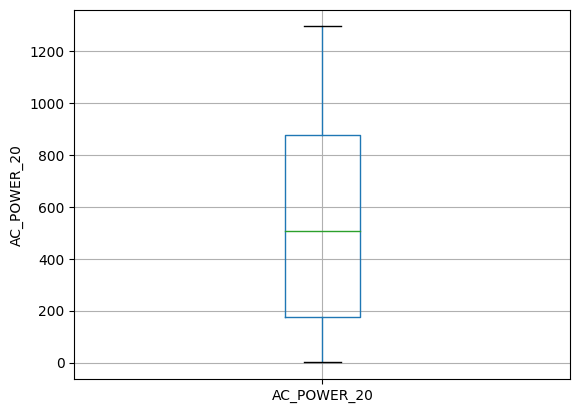

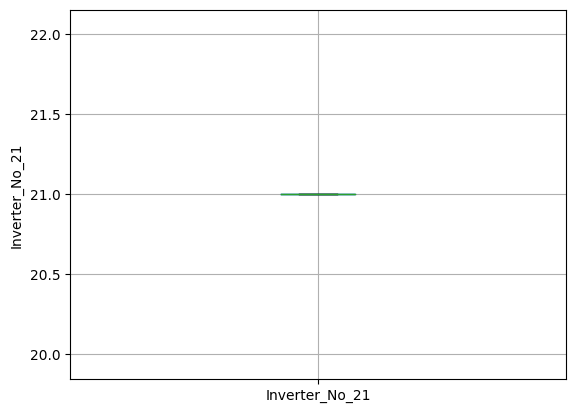

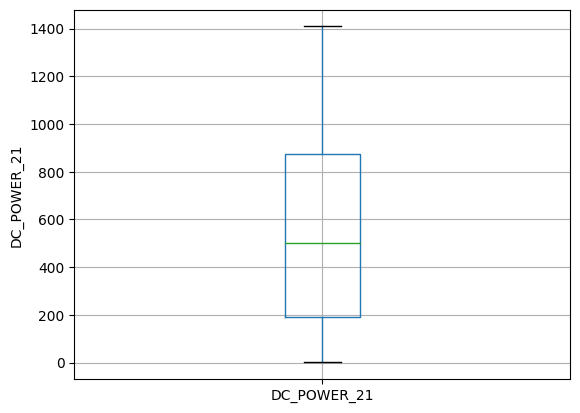

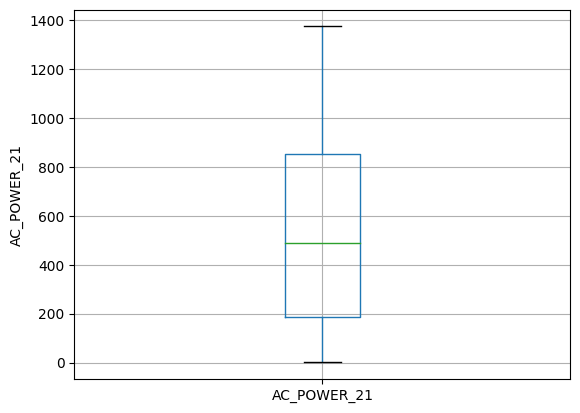

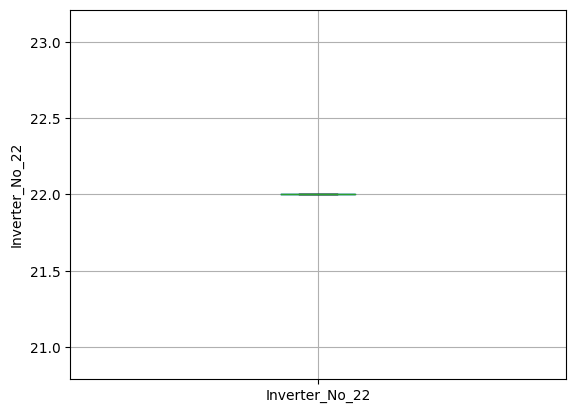

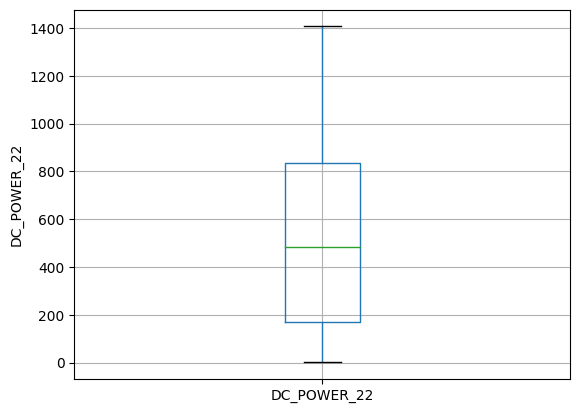

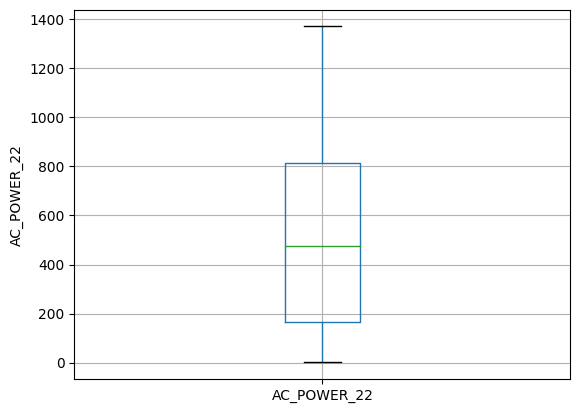

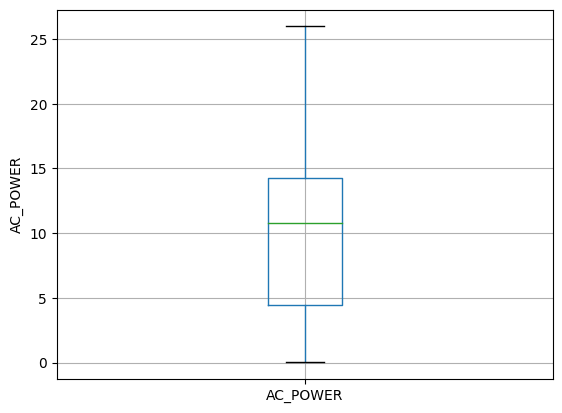

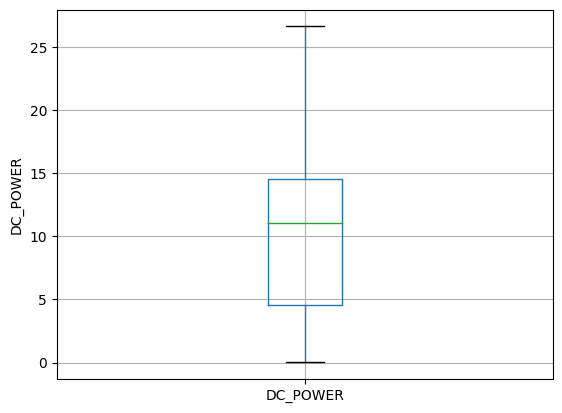

In [10]:
# Preliminary findings:
# Strong linear relation between AC Power & Irradiation and Module Temperature & Irradiation.
# Distributions of Irradiation, AC/DC Power are highly skewed to the right due to zero values for half of the day’s time being non-generating (6 pm-6 am), Ambient & Module Temperatures being slightly less skewed.
# Increasing variation in Module Temperature with each degree rise in Ambient temperature. Variation indicates the possibility of influence by other weather parameters like humidity level, wind speed, precipitation, etc. also which are absent in dataset.
# Presence of outliers in AC Power.
for feature in df_train.columns[3:]:
    # ignoring zero values for plotting
    df_train[df_train[feature]!=0].boxplot(column=feature)
    plt.ylabel(feature)
    plt.show()

In [11]:
#Handling outliers
df_train.drop('DC_POWER',axis=1,inplace=True)
percentile_dict = {}
for i in df_train.columns[3:]:
    a_list = []
    for j in [1,10,25,50,75,90,99,100]:
        a_list.append(round(np.percentile(df_train[i],j),2))
    percentile_dict[i] = a_list
pd.DataFrame(pd.concat([pd.DataFrame({'Percentiles':[1,10,25,50,75,90,99,100]}),pd.DataFrame(percentile_dict)],axis=1))


<ipython-input-11-92a64d7204ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('DC_POWER',axis=1,inplace=True)


,Percentiles,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Inverter_No_1,DC_POWER_1,AC_POWER_1,Inverter_No_2,DC_POWER_2,AC_POWER_2,...,Inverter_No_20,DC_POWER_20,AC_POWER_20,Inverter_No_21,DC_POWER_21,AC_POWER_21,Inverter_No_22,DC_POWER_22,AC_POWER_22,AC_POWER
0,1,22.55,21.10,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,0.00,22.0,0.00,0.00,0.00
1,10,23.66,22.40,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,0.00,22.0,0.00,0.00,0.00
2,25,24.73,23.76,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,0.00,22.0,0.00,0.00,0.00
3,50,27.24,27.79,0.02,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,0.00,22.0,0.00,0.00,0.46
4,75,31.55,41.75,0.46,1.0,535.66,525.04,2.0,402.93,395.81,...,20.0,482.34,473.00,21.0,312.62,307.05,22.0,426.71,418.87,11.23
5,90,34.61,52.28,0.80,1.0,1024.51,1000.20,2.0,871.89,853.11,...,20.0,961.87,939.29,21.0,844.76,826.37,22.0,883.88,864.01,15.28
6,99,37.40,60.32,0.96,1.0,1313.71,1280.86,2.0,1265.76,1234.17,...,20.0,1289.11,1256.91,21.0,1280.58,1248.68,22.0,1254.15,1223.16,19.54
7,100,39.18,66.64,1.10,1.0,1419.84,1384.35,2.0,1382.21,1347.66,...,20.0,1327.49,1294.30,21.0,1408.86,1373.65,22.0,1406.17,1371.01,25.98


In [12]:
#To handle outliers, All points lying beyond the 99 percentile and below 1 percentile shall be replaced with the 99th and 1st percentile respectively
outlier_imputer_dict = {}

for var in df_train.columns[3:]:
    percentile_dict = {}

    NinetyNine_percentile = np.percentile(df_train[var],99)

    First_percentile = np.percentile(df_train[var],1)

    percentile_dict['99th'] =  NinetyNine_percentile
    percentile_dict['1st'] =  First_percentile
    # Saving as dictionary for each column
    outlier_imputer_dict[var] = percentile_dict

#Saving the final dictionary
np.save('outlier_imputer_dict',outlier_imputer_dict)
# Define the outlier_imputer function
def outlier_imputer(df):
    # Loading Outlier Imputer dictionary
    outlier_dict = np.load('outlier_imputer_dict.npy', allow_pickle=True).item()

    for var in df.columns[3:]:
        if var in outlier_dict:
            df.loc[df[df[var] > outlier_dict[var]['99th']].index, var] = outlier_dict[var]['99th']
            df.loc[df[df[var] < outlier_dict[var]['1st']].index, var] = outlier_dict[var]['1st']

    return df
print(outlier_imputer_dict)
# Applying imputation on Train & Test data
df_train = outlier_imputer(df_train)
df_test = outlier_imputer(df_test)

{'AMBIENT_TEMPERATURE': {'99th': 37.39861080172414, '1st': 22.546186481034482}, 'MODULE_TEMPERATURE': {'99th': 60.32299286206897, '1st': 21.099540196666666}, 'IRRADIATION': {'99th': 0.9607427385333338, '1st': 0.0}, 'Inverter_No_1': {'99th': 1.0, '1st': 1.0}, 'DC_POWER_1': {'99th': 1313.7053333333336, '1st': 0.0}, 'AC_POWER_1': {'99th': 1280.8573333333336, '1st': 0.0}, 'Inverter_No_2': {'99th': 2.0, '1st': 2.0}, 'DC_POWER_2': {'99th': 1265.7593333333336, '1st': 0.0}, 'AC_POWER_2': {'99th': 1234.1740000000002, '1st': 0.0}, 'Inverter_No_3': {'99th': 3.0, '1st': 3.0}, 'DC_POWER_3': {'99th': 1257.8207142857143, '1st': 0.0}, 'AC_POWER_3': {'99th': 1226.3635714285713, '1st': 0.0}, 'Inverter_No_4': {'99th': 4.0, '1st': 4.0}, 'DC_POWER_4': {'99th': 1152.2673333333337, '1st': 0.0}, 'AC_POWER_4': {'99th': 1124.6880000000006, '1st': 0.0}, 'Inverter_No_5': {'99th': 5.0, '1st': 5.0}, 'DC_POWER_5': {'99th': 1292.5068095238098, '1st': 0.0}, 'AC_POWER_5': {'99th': 1260.6280000000002, '1st': 0.0}, 'Inve

In [13]:
#Now the dataset is clean
#Now moving towards model building
#For feeding balanced data to the model, we'll be using BIN a new column
#Each bin would represent a time duration during the day. For example, block(0-12) = BIN 1 and so on
#No. of bins
cut_blocks = [1,2,3,4,5,6,7,8]
#Bins range
cut_bins =[0, 12, 24, 36, 48, 60, 72, 84, 96]
#Assigning each row to a bin based on BLOCKS
df_train['BIN'] = pd.cut(df_train['BLOCK'], bins=cut_bins, labels = cut_blocks)
display(df_train)

<ipython-input-13-b13b6360d7e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BIN'] = pd.cut(df_train['BLOCK'], bins=cut_bins, labels = cut_blocks)


,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Inverter_No_1,DC_POWER_1,AC_POWER_1,Inverter_No_2,...,DC_POWER_20,AC_POWER_20,Inverter_No_21,DC_POWER_21,AC_POWER_21,Inverter_No_22,DC_POWER_22,AC_POWER_22,AC_POWER,BIN
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,1
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,1
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,1
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,1
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,92,2020-06-14,22:45,24.185657,22.922953,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,8
2967,93,2020-06-14,23:00,24.412542,23.356136,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,8
2968,94,2020-06-14,23:15,24.652915,23.913763,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,8
2969,95,2020-06-14,23:30,24.702391,24.185130,0.0,1.0,0.0,0.0,2,...,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0,0.0,8


In [14]:
!pip install scikeras[tensorflow]      # gpu compute platform
!pip install scikeras[tensorflow-cpu]  # cpu

In [15]:
!pip install tensorflow

In [16]:
!pip install scikeras


In [17]:
#Now the data is ready for training
#We will use 7 different regression algorithms with default parameters, including a 3 layered neural network regressor
# ANN Model
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import Sequential
from keras.layers import Dense

# Define the ANN_model function without nb_epoch argument
def ANN_model():
    # 3 layered Neural network with 500 epochs and 4 batch size
    reg = Sequential()
    reg.add(Dense(16, input_dim = 3, activation = 'relu'))
    reg.add(Dense(8, kernel_initializer='normal', activation = 'relu'))
    reg.add(Dense(1))
    reg.compile(loss='mean_squared_error', optimizer='adam')
    return reg

# Create KerasRegressor instance without specifying nb_epoch
ann_regressor = KerasRegressor(build_fn=ANN_model, batch_size=4, verbose=False)



#-----------------------------------X---------------------------------------------------------
#Importing models & Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## Pipeline for different Regression models
pipeline_lr = Pipeline([('lin_regression',LinearRegression())])
pipeline_dt = Pipeline([('dt_regression',DecisionTreeRegressor(random_state=0))])
pipeline_rf = Pipeline([('rf_regression',RandomForestRegressor(random_state=0))])
pipeline_ridge = Pipeline([('ridge_regression',Ridge(random_state=0))])
pipeline_lasso = Pipeline([('lasso_regression',Lasso(random_state=0))])
pipeline_xgboost = Pipeline([('xgboost_regression',XGBRegressor())])
pipeline_ann = Pipeline([('ann_regressor',ann_regressor)])

## Making a list of pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_ridge, pipeline_lasso, pipeline_xgboost, pipeline_ann]

best_rmse = 100.0
best_regressor = 0
best_pipeline = ""

## Dictionary of Pipelines and Regressor types for ease of reference
pipe_dict = {0:'Linear Regression',1: 'Decision Tree Regressor',2:'Random Forest Regressor',
             3:'Ridge Regressor',4:'Lasso Regressor',5:'XG Boost Regressor',6:'ANN Regressor'}

In [18]:
#We’ll be using Stratified k-folds based on the BINS column. This will help us get the same distribution of bins per fold.
#Model Evaluation.
#1. Split df_train into into 8 folds
#2. Use 7 folds for training(xtrain, ytrain), 8th fold for validation(xvalid, yvalid)
#3. Standardize the xtrain & xvalid generated in step 2
#4. Fit xtrain, ytrain on the model
#5. Predict on xvalid, find the RMSE value and store in a list
#6. Repeat steps 1–5 for 8 iterations and find mean of the list having RMSE scores to get model mean RMSE for 8 iterations
#7. Repeat steps 1–6 for each model in Pipeline list and compare the results

import warnings
warnings.filterwarnings("ignore")

# features to be used for training
useful_features = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

from sklearn.model_selection import StratifiedKFold
# Splitting data into 8 folds
skf = StratifiedKFold(n_splits=8, random_state=23, shuffle=True)
#Initializing kfold column
df_train['kfold'] = -1

# each row shall be assigned a fold no.based on 8 bins so that each fold will have equal representation of each bin
for fold,(train_indices, valid_indices) in enumerate(skf.split(X=df_train.iloc[:,:-1], y=df_train['BIN'])):
    df_train.loc[valid_indices, 'kfold'] = fold

# Will iterate through all the Pipelines one by one
for j, model in enumerate(pipelines):

    RMSE = list()
    for i in range(8):
        xtrain = df_train[df_train['kfold'] != i]
        xvalid = df_train[df_train['kfold'] == i]

        ytrain = xtrain.AC_POWER
        yvalid = xvalid.AC_POWER

        xtrain = xtrain[useful_features]
        xvalid = xvalid[useful_features]

        scaler = StandardScaler()
        scaler.fit_transform(xtrain)
        scaler.transform(xvalid)

        model.fit(xtrain, ytrain)
        rmse = np.sqrt(mean_squared_error(yvalid, model.predict(xvalid)))
        RMSE.append(rmse)

    # Mean of RMSE for all iterations for each model
    folds_mean_rmse = np.mean(RMSE)

    print('Mean Validation RMSE for {}: {}'.format(pipe_dict[j], folds_mean_rmse))

   # If mean of RMSE for all iterations reduces, call that model as the best & keep repeating
    # to get the best model
    if folds_mean_rmse < best_rmse:
        best_rmse = folds_mean_rmse
        best_pipeline = model
        best_regressor = j

print('\n\nRegressor with least RMSE:  {}'.format(pipe_dict[best_regressor]))
print(best_pipeline)

Mean Validation RMSE for Linear Regression: 2.3738425616651613
Mean Validation RMSE for Decision Tree Regressor: 2.3501314272965277
Mean Validation RMSE for Random Forest Regressor: 1.7376866079036648
Mean Validation RMSE for Ridge Regressor: 2.377400081890975
Mean Validation RMSE for Lasso Regressor: 2.79253288897248
Mean Validation RMSE for XG Boost Regressor: 1.877349022974213
Mean Validation RMSE for ANN Regressor: 3.4993768040432016


Regressor with least RMSE:  Random Forest Regressor
Pipeline(steps=[('rf_regression', RandomForestRegressor(random_state=0))])


In [22]:
from sklearn.ensemble import RandomForestRegressor

# Define the RandomForestRegressor model
rf_randomcv = RandomForestRegressor()

In [24]:
#Random forest Regressor has performed the best. Let’s go forward with this and tune its parameters
x_train = df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
# Ensure that the target variable y_train is in the correct format
y_train = df_train['AC_POWER'].values.ravel()

# Update the Random grid with a simplified search space
random_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

from sklearn.model_selection import RandomizedSearchCV
# Update the RandomizedSearchCV with a smaller number of iterations
rf_randomcv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, verbose=2, random_state=100, n_jobs=-1)

# Retry fitting RandomizedSearchCV on the training data
rf_randomcv.fit(x_train, y_train)

# Best parameters found in Random Search
print(rf_randomcv.best_params_)

# Create the RandomForestRegressor with the best parameters
rf_model = RandomForestRegressor(**rf_randomcv.best_params_)

# Fitting the RandomForestRegressor on the training set
rf_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200)

In [25]:
#Splitting into train and test
x_test = df_test[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION']]
y_test = df_test[['AC_POWER']]

#Predicting for x_test
y_pred_rf = rf_model.predict(x_test)

print(f'Root Mean Squared Error for Test Data: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}')

Root Mean Squared Error for Test Data: 1.878767841246471


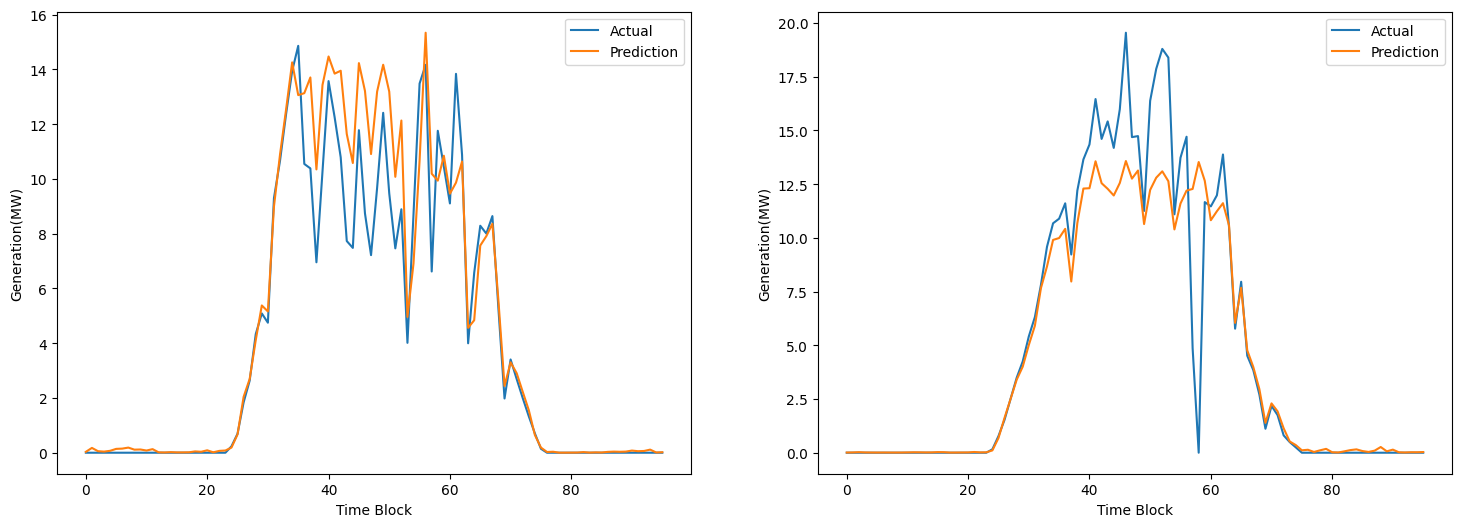

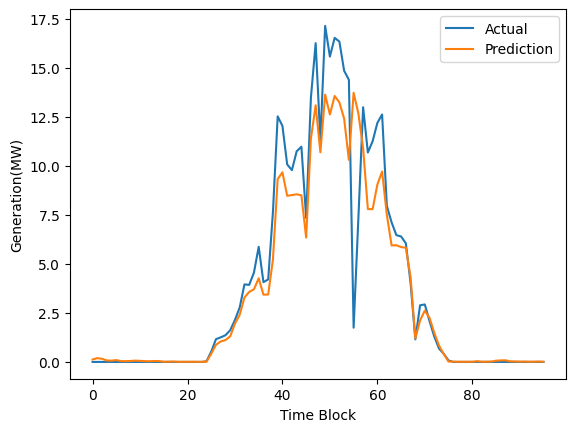

In [26]:
# Assuming y_test and y_pred_rf are the actual and predicted generation values for the last three days respectively
# Assuming you have 96 time blocks per day

# Combine actual and predicted values into a DataFrame
df_actual_vs_pred = pd.DataFrame({'Actual(MW)': y_test.values.ravel(), 'Prediction(MW)': y_pred_rf})

# Assuming df_actual_vs_pred has 288 rows for the last three days
# Add a time index for each time block
time_index = []
for day in range(1, 4):
    for block in range(1, 97):
        time_index.append(f'Day {day}, Block {block}')

# Add the time index to the DataFrame
df_actual_vs_pred['Time Block'] = time_index
df_actual_vs_pred.set_index('Time Block', inplace=True)

import matplotlib.pyplot as plt
# For Plot 1
f = plt.figure(figsize=(18,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# Day 1
ax1.plot(df_actual_vs_pred[['Actual(MW)','Prediction(MW)']][0:96].reset_index(drop=True))
ax2.plot(df_actual_vs_pred[['Actual(MW)','Prediction(MW)']][96:96*2].reset_index(drop=True))
ax1.set_xlabel('Time Block')
ax1.set_ylabel('Generation(MW)')
# Day 2
ax2.set_xlabel('Time Block')
ax2.set_ylabel('Generation(MW)')
ax1.legend(['Actual','Prediction'])
plt.legend(['Actual','Prediction'])
plt.show()
# Day 3
plt.plot(df_actual_vs_pred[['Actual(MW)','Prediction(MW)']][96*2:96*3].reset_index(drop=True))
plt.xlabel('Time Block')
plt.ylabel('Generation(MW)')
plt.legend(['Actual','Prediction'])
plt.show();

Enter time (HH:MM format): 12:34
Enter date (MM-DD format): 05-16
Enter number of solar inverters: 22


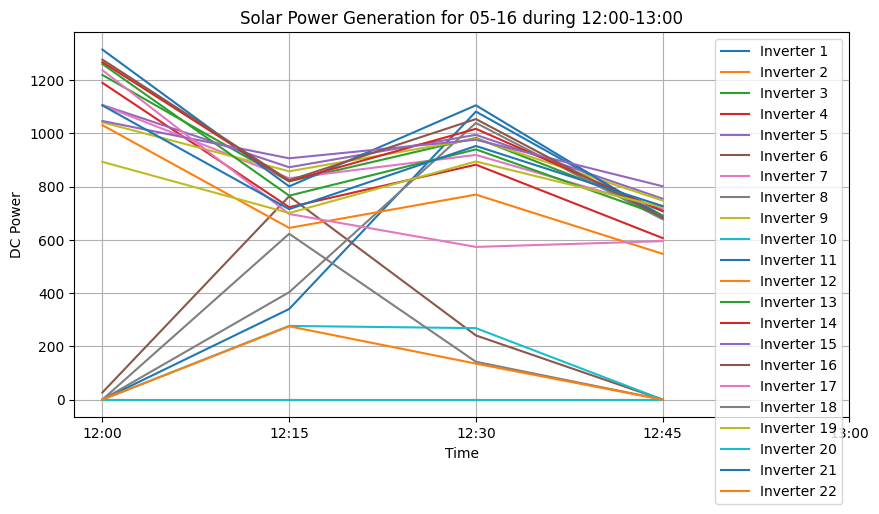

In [66]:
df['DATE_TIME'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))

def plot_solar_generation(df, date_input, time_input, num_inverters):
    fixed_year = 2020
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

    hour = pd.to_datetime(time_input).hour

    if hour < 6 or hour >= 17:
        print("No solar generation during non-sun hours (17:00 - 06:00). No graph will be generated.")
        return

    full_date_input = f"{fixed_year}-{date_input}"
    day_start = pd.to_datetime(f"{full_date_input} {hour}:00:00")
    day_end = pd.to_datetime(f"{full_date_input} {hour+1}:00:00")

    mask = (df['DATE_TIME'].dt.hour == hour) & (df['DATE_TIME'].dt.date == pd.to_datetime(full_date_input).date())
    df_filtered = df.loc[mask]

    if df_filtered.empty:
        print("No data available for the selected hour.")
        return

    plt.figure(figsize=(10, 5))
    time_ticks = pd.date_range(start=day_start, end=day_end, freq='15T')
    for i in range(1, num_inverters + 1):
        # Check and plot each inverter's data if available
        dc_power_col = f'DC_POWER_{i}'
        if dc_power_col in df_filtered.columns:
            plt.plot(df_filtered['DATE_TIME'], df_filtered[dc_power_col], label=f'Inverter {i}')

    plt.title(f'Solar Power Generation for {date_input} during {hour}:00-{hour+1}:00')
    plt.xlabel('Time')
    plt.ylabel('DC Power')
    plt.xticks(time_ticks, [t.strftime('%H:%M') for t in time_ticks])
    plt.legend()
    plt.grid(True)
    plt.show()

time_input = input("Enter time (HH:MM format): ")
date_input = input("Enter date (MM-DD format): ")
num_inverters = int(input("Enter number of solar inverters: "))
plot_solar_generation(df, date_input, time_input, num_inverters)


